In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import sys
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# need to do this to read .h5 files
!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [4]:
# load training dataset and validation dataset
training_data = '/content/drive/My Drive/data/Wang-ML-data/train_daytime_forest.h5'
validation_data = '/content/drive/My Drive/data/Wang-ML-data/valid_daytime_forest.h5'
pd_forest = pd.read_hdf(training_data,key='forest')
vd_forest = pd.read_hdf(validation_data,key='forest')

In [5]:
#show data frame structures
print (pd_forest.columns)

Index(['Lon', 'Lat', 'VZA', 'Mu', 'SZA', 'Mu0', 'VAA', 'SAA', 'IGBP', 'SNIC',
       'Skin_T', 'E14', 'E15', 'E16', 'BTS14', 'BTS15', 'BTS16', 'R01', 'R02',
       'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'B12',
       'B13', 'B14', 'B15', 'B16', 'CMASK', 'CPhase', 'VIIRS_CMASK',
       'VIIRS_OPPhase', 'VIIRS_CTPhase'],
      dtype='object')


In [6]:
# remove bad points and complicated cases
training_x_data = pd_forest.loc[
                  ( pd_forest['B12']>100. ) &
                  ( pd_forest['B13']>100. ) &
                  ( pd_forest['B14']>100. ) &
                  ( pd_forest['B15']>100. ) &
                  ( pd_forest['B16']>100. ) &
                  ( pd_forest['B12']<400. ) &
                  ( pd_forest['B13']<400. ) &
                  ( pd_forest['B14']<400. ) &
                  ( pd_forest['B15']<400. ) &
                  ( pd_forest['B16']<400. ) &
                  ( pd_forest['CPhase']!='IOL' ) &
                  ( pd_forest['SZA']<=83 ) &
                  ( pd_forest['SZA']>=0 ) &
                  ( pd_forest['R07']>0.0)
                  ]

validation_x_data = vd_forest.loc[
                  ( vd_forest['B12']>100. ) &
                  ( vd_forest['B13']>100. ) &
                  ( vd_forest['B14']>100. ) &
                  ( vd_forest['B15']>100. ) &
                  ( vd_forest['B16']>100. ) &
                  ( vd_forest['B12']<400. ) &
                  ( vd_forest['B13']<400. ) &
                  ( vd_forest['B14']<400. ) &
                  ( vd_forest['B15']<400. ) &
                  ( vd_forest['B16']<400. ) &
                  ( vd_forest['CPhase']!='IOL' ) &
                  ( vd_forest['SZA']<=83 ) &
                  ( vd_forest['SZA']>=0 ) &
                  ( vd_forest['R07']>0.0)
                  ]

#release memory
del pd_forest
del vd_forest

In [7]:
# generate training and testing samples

t1_X = np.full([len(training_x_data),13],0,dtype='f4')
t1_Y = np.full([len(training_x_data)],'xxx',dtype='<U3')

t1_X[:, 0] = training_x_data.Mu0.values
t1_X[:, 1] = training_x_data.Mu.values
t1_X[:, 2] = training_x_data.B14.values
t1_X[:, 3] = training_x_data.B15.values
t1_X[:, 4] = training_x_data.B16.values
t1_X[:, 5] = training_x_data.B14.values - training_x_data.B15.values
t1_X[:, 6] = training_x_data.B15.values - training_x_data.B16.values
t1_X[:, 7] = training_x_data.R07.values
t1_X[:, 8] = training_x_data.R09.values/training_x_data.R07.values
t1_X[:, 9] = training_x_data.R10.values/training_x_data.R07.values
t1_X[:,10] = training_x_data.R11.values/training_x_data.R07.values
t1_X[:,11] = training_x_data.Lat.values
t1_X[:,12] = training_x_data.Lon.values
t1_Y = training_x_data.CPhase.values

del training_x_data

# separate the training set into two parts (traing 70% and testing 30%)
testing_size = 0.30
seed = 7
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(t1_X,t1_Y,test_size=testing_size,random_state=seed)

In [8]:
# check the size of training and testing parts
print (train_X.shape,train_Y.shape)
print (test_X.shape, test_Y.shape)

(1611652, 13) (1611652,)
(690709, 13) (690709,)


In [9]:
# Define Random Forest parameters
n_estimators = 150
max_depth = 15
bootstrap = True
criterion = 'entropy'
class_weight = None
random_state = 123456
n_job = -1

In [11]:
rfforest = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, criterion=criterion,
                                  max_depth=max_depth, oob_score=False, verbose=3,
                                  class_weight=class_weight, random_state=random_state, n_jobs=n_job)
print ('Training RandomForest')
rfforest.fit(train_X,train_Y.ravel())

Training RandomForest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.3min


building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 18.6min


building tree 126 of 150
building tree 127 of 150
building tree 128 of 150
building tree 129 of 150
building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=123456,
                       verbose=3, warm_start=False)

In [12]:
print ('Testing Performance')
test_predict_Y = rfforest.predict(test_X)
test_predict_YP = rfforest.predict_proba(test_X)
print(accuracy_score(test_Y, test_predict_Y))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Testing Performance


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   14.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   15.9s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   18.5s finished


0.927578763270784


In [13]:
# validation

v1_X = np.full([len(validation_x_data),13],0,dtype='f4')
v1_Y = np.full([len(validation_x_data)],'xxx',dtype='<U3')

v1_X[:, 0] = validation_x_data.Mu0.values
v1_X[:, 1] = validation_x_data.Mu.values
v1_X[:, 2] = validation_x_data.B14.values
v1_X[:, 3] = validation_x_data.B15.values
v1_X[:, 4] = validation_x_data.B16.values
v1_X[:, 5] = validation_x_data.B14.values - validation_x_data.B15.values
v1_X[:, 6] = validation_x_data.B15.values - validation_x_data.B16.values
v1_X[:, 7] = validation_x_data.R07.values
v1_X[:, 8] = validation_x_data.R09.values/validation_x_data.R07.values
v1_X[:, 9] = validation_x_data.R10.values/validation_x_data.R07.values
v1_X[:,10] = validation_x_data.R11.values/validation_x_data.R07.values
v1_X[:,11] = validation_x_data.Lat.values
v1_X[:,12] = validation_x_data.Lon.values
v1_Y = validation_x_data.CPhase.values

print ('Validation Performance')
validation_predict_Y = rfforest.predict(v1_X)
validation_predict_YP = rfforest.predict_proba(v1_X)
print(accuracy_score(v1_Y, validation_predict_Y))

Validation Performance


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    4.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    4.8s finished


0.927688360795928


In [14]:
# save trained model
joblib.dump(rfforest, 'test.model')

['test.model']

In [15]:
# load existing model
rfforest = joblib.load('test.model')

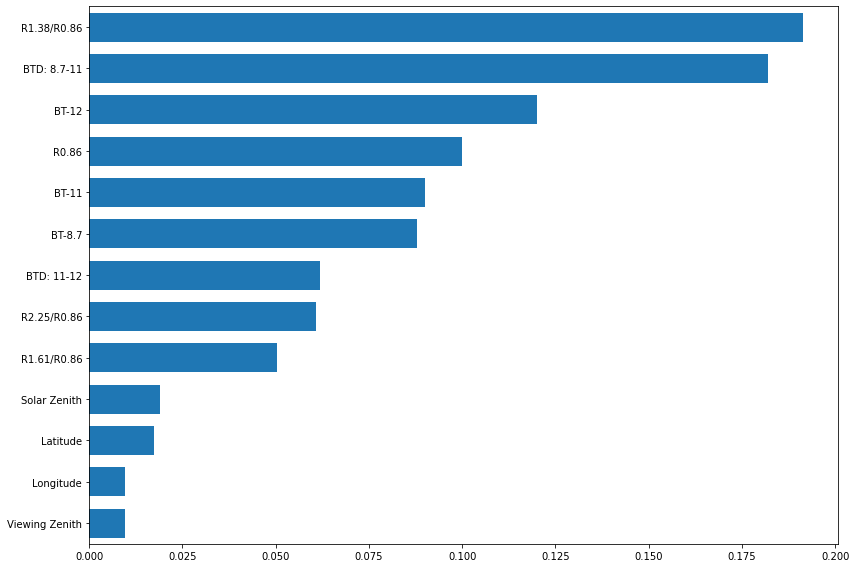

In [16]:
# show feature importance:
feature_names = np.array(['Solar Zenith','Viewing Zenith', 'BT-8.7', 'BT-11', 'BT-12', 'BTD: 8.7-11', 'BTD: 11-12',
                 'R0.86','R1.38/R0.86','R1.61/R0.86','R2.25/R0.86','Latitude','Longitude'])
tree_importance_sorted_idx = np.argsort(rfforest.feature_importances_)
tree_indices = np.arange(0, len(rfforest.feature_importances_)) + 0.5
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices,
         rfforest.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rfforest.feature_importances_)))

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Liquid Water Cloud Probability Distribution')

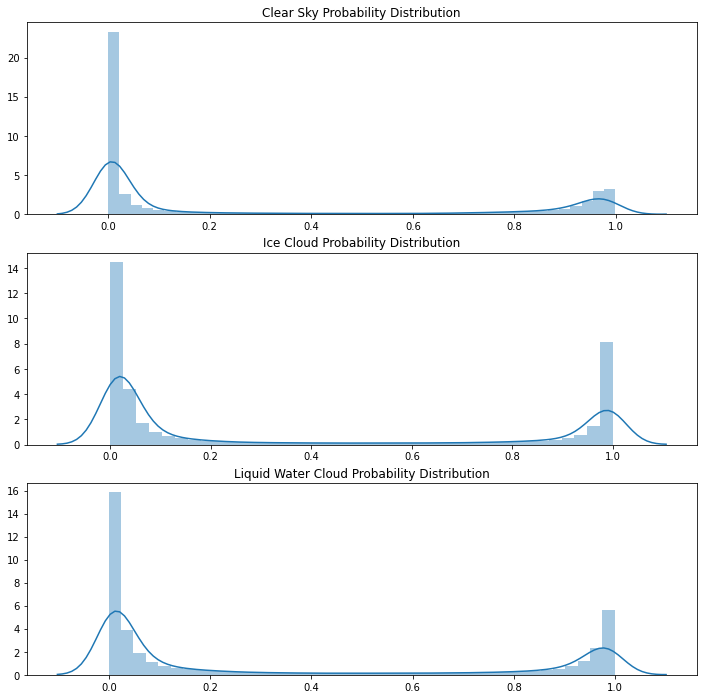

In [17]:
#show probability distribution functions
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(12, 12))
sns.distplot(validation_predict_YP[:,0],ax=ax1); # clear sky probability
sns.distplot(validation_predict_YP[:,1],ax=ax2); # Ice Cloud probability
sns.distplot(validation_predict_YP[:,2],ax=ax3); # Liquid Water Cloud probability
ax1.set_title('Clear Sky Probability Distribution')
ax2.set_title('Ice Cloud Probability Distribution')
ax3.set_title('Liquid Water Cloud Probability Distribution')

Confusion matrix, without normalization
[[102597   2583   3919]
 [  4022 123893   5794]
 [  5387   4762 113056]]


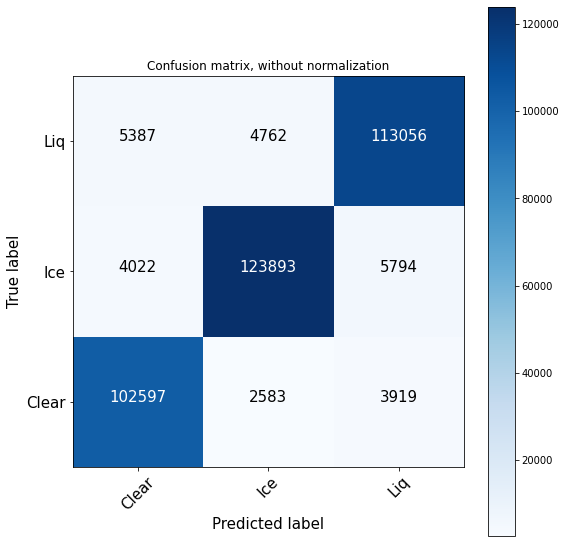

In [19]:
# show confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))

    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=15)
    plt.yticks(tick_marks, classes, size=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black", size=15)

    plt.ylabel('True label',size=15)
    plt.xlabel('Predicted label',size=15)
    plt.ylim([-0.5,-0.5+len(classes)])
    plt.tight_layout()


CM = confusion_matrix(v1_Y, validation_predict_Y)

plot_confusion_matrix(CM, classes=['Clear', 'Ice', 'Liq'],
                      title='Confusion matrix, without normalization')
plt.show()